# Starbucks Capstone Challenge

## Project Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. The informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

The transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

## Problem Statement

The task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. Based on that, this project will focus on:
- what are the main features that affect someone on responding the offers
- build model to predict whether or not someone will respond to an offer

In [425]:
# import libraries
import pandas as pd
import numpy as np
import math
import json

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, classification_report

from time import time

## Data Exploration

In [426]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### 1. Portfolio Dataset
**portfolio.json** - containing offer ids and meta data about each offer (duration, type, etc.)
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [427]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


The protfolio data shows 10 different offers. Before doing further exploration, let's applying one hot encoding to categorical column.

In [428]:
def clean_portfolio(portfolio):
    '''
    data cleaning steps for portfolio dataset
    
    INPUT:
    portfolio - the dataframe to be cleaned
    
    OUTPUT:
    cleaned_portfolio - the cleaned dataframe
    '''   
    
    cleaned_portfolio = portfolio.copy()

    # apply one hot encoding to categorical column  
    for channel in ['web', 'email', 'mobile', 'social']:
        cleaned_portfolio[channel] = cleaned_portfolio['channels'].apply(lambda x: 1 if channel in x else 0)
            
    # drop the original columns and combined with the new dummy columns
    cleaned_portfolio.drop(columns = ['channels'], inplace=True)
    
    # rename id column to offer_id
    cleaned_portfolio.rename(columns={'id':'offer_id'},inplace=True)
    
    return cleaned_portfolio

In [429]:
cleaned_portfolio = clean_portfolio(portfolio)

In [430]:
cleaned_portfolio

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


### 2. Profile Dataset
**profile.json** - demographic data for each customer
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [431]:
profile.head(5)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [432]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [433]:
# check missing value
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

plot some simple histograms to show the distributions among all users.

<AxesSubplot:>

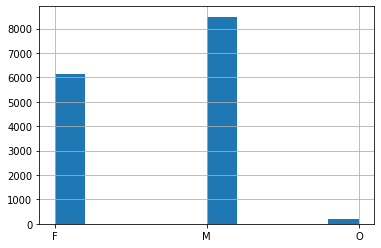

In [434]:
profile.gender.hist()

<AxesSubplot:>

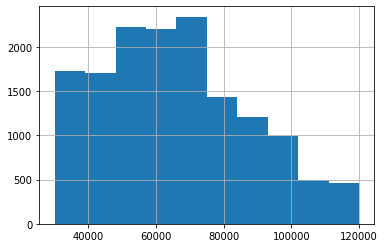

In [435]:
profile.income.hist()

<AxesSubplot:>

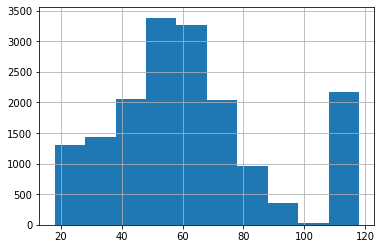

In [436]:
profile.age.hist()

In [437]:
profile.age.max()

118

As we can see, there are over 2000 customers with age 118 which seems invalid and consistent with the number of observations with missing gender/income. So let's drop those rows with age 118 and check if there're still missing values in gender/income column.

In [438]:
profile[profile.age < 118].isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

Now, clean the profile data by removing missing values, label encoding for gender, and calculate the number of days since the customer became the member.

In [439]:
def clean_profile(profile):
    '''
    data cleaning steps for profile dataset
    
    INPUT:
    profile - the dataframe to be cleaned
    
    OUTPUT:
    cleaned_profile - the cleaned dataframe
    '''
    
    # drop rows with age 118
    cleaned_profile = profile[profile.age < 118]
    
    # label encoding for gender
    # Female 0, Male 1, Other 2
    label = LabelEncoder() 
    cleaned_profile['gender']= label.fit_transform(cleaned_profile['gender']) 
    
    # calculate the number of days since membership
    cleaned_profile['member_days'] = (datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date).dt.days
 
   # drop became_member_on column
    cleaned_profile = cleaned_profile.drop(['became_member_on'], axis=1)

    # rename id column to customer_id
    cleaned_profile.rename(columns={'id':'customer_id'},inplace=True)
    
    return cleaned_profile

In [440]:
cleaned_profile = clean_profile(profile)

/tmp/ipykernel_34734/2115819475.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_profile['gender']= label.fit_transform(cleaned_profile['gender'])
/tmp/ipykernel_34734/2115819475.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_profile['member_days'] = (datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date).dt.days


In [441]:
cleaned_profile.head(5)

,gender,age,customer_id,income,member_days
1,0,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1783
3,0,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1850
5,1,68,e2127556f4f64592b11af22de27a7932,70000.0,1498
8,1,65,389bc3fa690240e798340f5a15918d5c,53000.0,1574
12,1,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1664


In [442]:
cleaned_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gender       14825 non-null  int64  
 1   age          14825 non-null  int64  
 2   customer_id  14825 non-null  object 
 3   income       14825 non-null  float64
 4   member_days  14825 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 694.9+ KB


<AxesSubplot:>

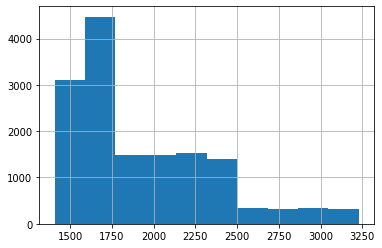

In [443]:
cleaned_profile.member_days.hist()

**Some quick observations on the users:**
- There are more male members than female
- The most common age range among all members is 50-60
- Most members have a income in range 50000 - 80000
- Most customers have the membership about 4-5 years

### 3. Transcript Dataset
**transcript.json** - records for transactions, offers received, offers viewed, and offers completed
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [444]:
transcript.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [445]:
# check missing value
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [446]:
# check all possible events
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [447]:
transcript.groupby('event').person.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

In [448]:
transcript[transcript['event'] == 'offer received'].head(3)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


In [449]:
transcript[transcript['event'] == 'offer viewed'].head(3)

,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [450]:
transcript[transcript['event'] == 'offer completed'].head(3)

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0


In [451]:
transcript[transcript['event'] == 'transaction'].head(3)

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0


Based on the dataset description and exploration, we can extract "offer id" or "amount" from "value" column depending on the record event. Notice that for event "offer completed", the value column is "offer_id" instead of "offer id" for the other two events.

In [452]:
def clean_transcript(transcript):
    '''
    data cleaning steps for transcript dataset
    
    INPUT:
    transcript - the dataframe to be cleaned
    
    OUTPUT:
    cleaned_transcript - the cleaned dataframe
    '''
    
    cleaned_transcript = transcript.copy()
    
    # extract offer id or amount from value column
    cleaned_transcript['offer id'] = cleaned_transcript['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else None)
    cleaned_transcript['offer_id'] = cleaned_transcript['value'].apply(lambda x: x['offer_id'] if ('offer_id' in x) else None)
    cleaned_transcript['amount'] = cleaned_transcript['value'].apply(lambda x: x['amount'] if ('amount' in x) else None)
    
    # combine two offer id columns
    cleaned_transcript['combine_id'] = np.where(cleaned_transcript['offer id'].isnull() & cleaned_transcript['offer_id'].notnull(), cleaned_transcript['offer_id'], cleaned_transcript['offer id'])
    
    # drop original columns
    cleaned_transcript.drop(columns = ['offer_id', 'offer id', 'value'], inplace=True)
    
    # rename columns
    cleaned_transcript.rename(columns={'combine_id':'offer_id', 'person':'customer_id'},inplace=True)
    
    return cleaned_transcript

In [453]:
cleaned_transcript = clean_transcript(transcript)

In [454]:
cleaned_transcript.head(5)

,customer_id,event,time,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


## Data Preprocessing

### 1. Combine Data

Now, we have done some basic cleaning steps on the three datasets. In order to do the further analysis and implementation, we need to preprocess three datasats. First step would be merge them together by linking the offer id and customer id from portfolio and profile data onto the transcript data.

In [455]:
full_df = cleaned_transcript.merge(cleaned_portfolio, how='left', on='offer_id')
full_df = full_df.merge(cleaned_profile, how='left', on='customer_id')

In [456]:
full_df[full_df['age'].isnull()].head(1)

,customer_id,event,time,amount,offer_id,reward,difficulty,duration,offer_type,web,email,mobile,social,gender,age,income,member_days
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN


In [457]:
profile[profile['id'] == 'a03223e636434f42ac4c3df47e8bac43']

,gender,age,id,became_member_on,income
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [458]:
# drop rows with customer id that cannot find in cleaned_profile dataset
# in that case, those customers are the ones dropped because of age outlier (i.e. 118)
full_df.dropna(subset=['age'], inplace=True)

In [459]:
full_df.head(5)

,customer_id,event,time,amount,offer_id,reward,difficulty,duration,offer_type,web,email,mobile,social,gender,age,income,member_days
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,0.0,75.0,100000.0,1850.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,1.0,68.0,70000.0,1498.0
5,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,1.0,65.0,53000.0,1574.0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,informational,1.0,1.0,1.0,0.0,1.0,58.0,51000.0,1664.0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,0.0,61.0,57000.0,1725.0


In [460]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 306532
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   customer_id  272762 non-null  object 
 1   event        272762 non-null  object 
 2   time         272762 non-null  int64  
 3   amount       123957 non-null  float64
 4   offer_id     148805 non-null  object 
 5   reward       148805 non-null  float64
 6   difficulty   148805 non-null  float64
 7   duration     148805 non-null  float64
 8   offer_type   148805 non-null  object 
 9   web          148805 non-null  float64
 10  email        148805 non-null  float64
 11  mobile       148805 non-null  float64
 12  social       148805 non-null  float64
 13  gender       272762 non-null  float64
 14  age          272762 non-null  float64
 15  income       272762 non-null  float64
 16  member_days  272762 non-null  float64
dtypes: float64(12), int64(1), object(4)
memory usage: 37.5+ MB


In [461]:
# quick view on event distribution by offer_type
full_df.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15258
                 discount         17186
offer received   bogo             26537
                 discount         26664
                 informational    13300
offer viewed     bogo             22039
                 discount         18461
                 informational     9360
Name: offer_type, dtype: int64

### 2. Subset and Reshape Data

From the above exploration, we noticed that for informational offer, there is no 'offer complated' event. And given that all transaction events don't include the offer id, so it's relatively hard to figure out if an informational offer is completed or if the offer is effective. 

But, we can use the time sequence of the events to figure out if a bogo/discount offer influenced a customer's purchase. More specifically:

1. Customer viewed and completed the offer - successful offer:
    
    offer received -> offer viewed -> offer completed
    
    
2. Customer did not complete the offer after viewed the offer - unsuccessful offer:

    offer received -> offer viewed

For group 1, we can assume that the customer reacts postively or influenced by the offer, so consider as a successful offer. Group 2 can be considered as an unsuccessful offer.

So, we'll focus on bogo and discount offers for now, and reshape the data to define if the offer is successful or not.

In [462]:
# only keep events related to bogo and discount offers
subset_df = full_df[full_df['offer_type'].isin(['bogo', 'discount'])]
# drop amount column b/c we dropped all transaction events (don't need to identify effective offer)
subset_df = subset_df.drop(columns=['amount'])

In [463]:
# sort by customer id, offer id and time
subset_df = subset_df.sort_values(['customer_id', 'offer_id', 'time'])

In [464]:
subset_df.head(5)

,customer_id,event,time,offer_id,reward,difficulty,duration,offer_type,web,email,mobile,social,gender,age,income,member_days
247879,0009655768c64bdeb2e877511632db8f,offer received,576,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,1.0,33.0,72000.0,1868.0
258884,0009655768c64bdeb2e877511632db8f,offer completed,576,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,1.0,33.0,72000.0,1868.0
153401,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,1.0,33.0,72000.0,1868.0
168413,0009655768c64bdeb2e877511632db8f,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,1.0,33.0,72000.0,1868.0
187554,0009655768c64bdeb2e877511632db8f,offer viewed,456,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,1.0,33.0,72000.0,1868.0


Before we transpose the data, we found there are some duplicated cases where the same offer sent to the same customer multiple times.

In [465]:
# a duplicated case example
subset_df[(subset_df['customer_id'] == 'ffff82501cea40309d5fdd7edcca4a07') & (subset_df['offer_id'] == '2906b810c7d4411798c6938adc9daaa5')]

,customer_id,event,time,offer_id,reward,difficulty,duration,offer_type,web,email,mobile,social,gender,age,income,member_days
112214,ffff82501cea40309d5fdd7edcca4a07,offer received,336,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,0.0,45.0,62000.0,2015.0
133074,ffff82501cea40309d5fdd7edcca4a07,offer viewed,354,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,0.0,45.0,62000.0,2015.0
143788,ffff82501cea40309d5fdd7edcca4a07,offer completed,384,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,0.0,45.0,62000.0,2015.0
152030,ffff82501cea40309d5fdd7edcca4a07,offer received,408,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,0.0,45.0,62000.0,2015.0
168022,ffff82501cea40309d5fdd7edcca4a07,offer viewed,414,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,0.0,45.0,62000.0,2015.0
168024,ffff82501cea40309d5fdd7edcca4a07,offer completed,414,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,0.0,45.0,62000.0,2015.0
246495,ffff82501cea40309d5fdd7edcca4a07,offer received,576,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,0.0,45.0,62000.0,2015.0
258362,ffff82501cea40309d5fdd7edcca4a07,offer completed,576,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,0.0,45.0,62000.0,2015.0
262475,ffff82501cea40309d5fdd7edcca4a07,offer viewed,582,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,0.0,45.0,62000.0,2015.0


In that case, I decide to use the earliest time for each event when doing the tranpose. This may not be a perfect solution, so we can think of more options to dedup in the future.

In [466]:
# transpose the data from long to wide
subset_df_wide = subset_df.pivot_table(index=['customer_id','offer_id'], columns='event', values='time', aggfunc='min')

# convert pivot table back to dataframe
subset_df_wide = pd.DataFrame(subset_df_wide.to_records())

subset_df_wide.rename(columns={'offer completed':'offer_completed',
                               'offer received':'offer_received',
                               'offer viewed':'offer_viewed'},inplace=True)

In [467]:
# merge back other information
subset_df_wide = subset_df_wide.merge(cleaned_portfolio, how='left', on='offer_id')
subset_df_wide = subset_df_wide.merge(cleaned_profile, how='left', on='customer_id')

In [468]:
# only consider group 1 & 2
subset_df_wide = subset_df_wide[(subset_df_wide['offer_viewed'].notnull()) & (subset_df_wide['offer_completed'].isnull()) |
                                (subset_df_wide['offer_received'] <= subset_df_wide['offer_viewed']) & (subset_df_wide['offer_viewed'] <= subset_df_wide['offer_completed'])]

# use time of each event to define the offer's effectiveness
conditions = [(subset_df_wide['offer_viewed'].notnull()) & (subset_df_wide['offer_completed'].isnull()),
              (subset_df_wide['offer_received'] <= subset_df_wide['offer_viewed']) & 
              (subset_df_wide['offer_viewed'] <= subset_df_wide['offer_completed'])]

# values: 0 -> unsuccessful
#         1 -> successful
values = [0, 1]

subset_df_wide['offer_effective'] = np.select(conditions, values)

In [469]:
# drop useless columns
final_df = subset_df_wide.drop(columns=['offer_completed','offer_received','offer_viewed'], axis=1,inplace=False)

In [470]:
final_df.head(5)

,customer_id,offer_id,reward,difficulty,duration,offer_type,web,email,mobile,social,gender,age,income,member_days,offer_effective
3,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount,1,1,0,0,2,40,57000.0,1605,1
4,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,discount,1,1,1,1,2,40,57000.0,1605,1
5,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,1,0,2,40,57000.0,1605,1
6,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,bogo,1,1,1,1,0,59,90000.0,2281,1
8,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,discount,1,1,1,1,0,59,90000.0,2281,1


In [471]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30788 entries, 3 to 44180
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      30788 non-null  object 
 1   offer_id         30788 non-null  object 
 2   reward           30788 non-null  int64  
 3   difficulty       30788 non-null  int64  
 4   duration         30788 non-null  int64  
 5   offer_type       30788 non-null  object 
 6   web              30788 non-null  int64  
 7   email            30788 non-null  int64  
 8   mobile           30788 non-null  int64  
 9   social           30788 non-null  int64  
 10  gender           30788 non-null  int64  
 11  age              30788 non-null  int64  
 12  income           30788 non-null  float64
 13  member_days      30788 non-null  int64  
 14  offer_effective  30788 non-null  int64  
dtypes: float64(1), int64(11), object(3)
memory usage: 3.8+ MB


Finally, let's separate the data into 2 dataframes for BOGO & Discount offer.

In [472]:
bogo_df = final_df[final_df['offer_type'] == 'bogo'].drop(['offer_type'], axis=1)
disc_df = final_df[final_df['offer_type'] == 'discount'].drop(['offer_type'], axis=1)

## Model Implementation & Evaluation

Now, we have the datasets and ready for the model implementation. Our goal is to predict whether or not someone will respond to an offer. In order to achieve that, we are going to use classification model to predict the target "offer_effective". And we'll build the model for BOGO and Discount offer separately.

### 1. Preparation 

Before the model implementation, let's do some checks on our data.

First, let's check on the correlation between all features (excluding the target). We can also exclude customer_id, offer_id, and offer_type because we're interested in seeing the impact of those feature of the customers or the offers on the offer effectiveness.

In [473]:
bogo_df_map = bogo_df.drop(['customer_id', 'offer_id', 'offer_effective'], axis=1)
disc_df_map = disc_df.drop(['customer_id', 'offer_id', 'offer_effective'], axis=1)

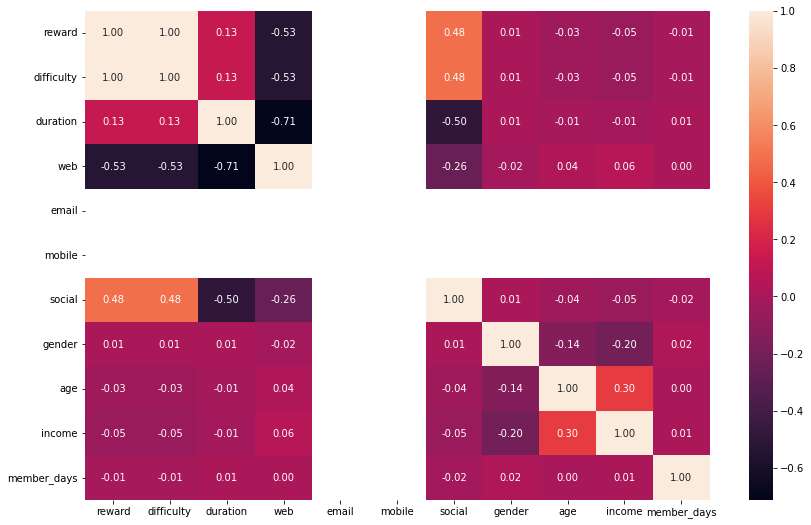

In [474]:
plt.figure(figsize=(14,9))
sns.heatmap(bogo_df_map.corr(), annot=True, fmt=".2f");

From the correlation result, we could tell that "reward" and "difficulty" are perfect correlated for BOGO offer, which absolutely makes sense because that's why it calls buy 1 get 1 free. So when we implement the model, we'll combine those two as a single 0.5 discount rate. Also we noticed that there's no result for "email" and "mobile". That's because all values are 1 for those two columns, which indicates that for BOGO offer, Starbucks always send via email and mobile, so drop both of them. 

In [475]:
# discount rate
bogo_df['discount_rate'] = 0.5
# drop features
bogo_df = bogo_df.drop(['reward', 'difficulty', 'email', 'mobile'], axis=1)

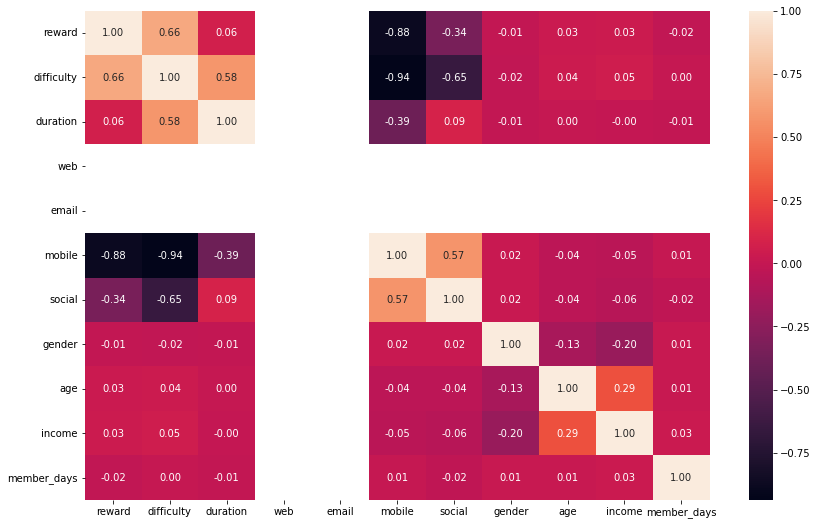

In [476]:
plt.figure(figsize=(14,9))
sns.heatmap(disc_df_map.corr(), annot=True, fmt=".2f");

Similarly as above, we'll drop "web" and "email" for Discount offer model implementation, and combine "reward" and "difficulty" into a single discount rate feature.

In [477]:
# discount rate
disc_df['discount_rate'] = disc_df['reward'] / disc_df['difficulty']
# drop features
disc_df = disc_df.drop(['reward', 'difficulty', 'web', 'mobile'], axis=1)

Next, let's check on the balance of the target.

In [478]:
# check data balance
print("BOGO Offer:")
print(bogo_df[['customer_id','offer_effective']].groupby('offer_effective').count()/bogo_df.shape[0])
print("----------------------------")
print("Discount Offer:")
print(disc_df[['customer_id','offer_effective']].groupby('offer_effective').count()/disc_df.shape[0])

BOGO Offer:
                 customer_id
offer_effective             
0                    0.43083
1                    0.56917
----------------------------
Discount Offer:
                 customer_id
offer_effective             
0                   0.266714
1                   0.733286


For Discount offer, the target classes are a bit uneven, but overall it's not too bad. In that case, I'll use Random Forest Classifier model to deal with the imbalance cases. Also when we evaluate the model, consider F1 score as well besides the accuracy score.

In data exploration, we already checked the distribution of some features, like gender, age, income and member_days. From the histograms, the data doesn't have the imbalance issue for the features neither.

### 2. Implementation

Now we're ready for the model implementation. For both offer types, I'll use the Random Forest Classifier model.

In [479]:
def prep_model(df, drop_col, stand_col):
    """
    prepare for the model implementation
    
    INPUT:
    df: dataframe for X and Y
    drop_col: columns to drop from features
    stand_col: features to be standardized
    
    OUTPUT:
    X_train, X_test, y_train, y_test
    """
    
    # split data into independent features and target
    X = df.drop(drop_col, axis=1)
    Y = df['offer_effective']
    
    # split into training and test dataset
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=13)
    
    # Standardizing selected features
    ct = ColumnTransformer([("stand", StandardScaler(), stand_col)],
                           verbose_feature_names_out = False,
                           remainder='passthrough')    
    X_train = ct.fit_transform(X_train)
    X_test = ct.fit_transform(X_test)

    cols = ct.get_feature_names_out()

    X_train = pd.DataFrame(X_train, columns=cols)
    X_test = pd.DataFrame(X_test, columns=cols)
    
    return X_train, X_test, y_train, y_test

In [480]:
def build_model(X_train, X_test, y_train, y_test, model):
    """
    build and fit the classification model onto the data
    
    INPUT:
    X_train, X_test, y_train, y_test
    model: model to be used for fit and prediction
    
    OUTPUT:
    output model performance evaluation 
    """
    
    results = {}
    
    # record the model training time
    start_train = time()     
    # fit the model on training data
    model.fit(X_train, y_train)   
    end_train = time() 
    
    results['training_time'] = end_train - start_train
    
    # record the model prediction time
    start_pred = time()     
    # predict on test/training data
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    end_pred = time() 
    
    results['prediction_time'] = end_pred - start_pred
    
    # training/test accuracy
    results['training_score']=model.score(X_train,y_train)
    results['testing_score']=model.score(X_test,y_test)    

    print("Model training time: %.4f" % results['training_time'])
    print("Model prediction time: %.4f" % results['prediction_time'])
    print("{} trained on {} samples.".format(model.__class__.__name__, len(y_train)))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])    
    print(classification_report(y_test, y_test_pred))
    
    return results

i. BOGO Offer Model

In [481]:
# BOGO Offer Model
drop_col=['customer_id', 'offer_id', 'offer_effective']
stand_col=['discount_rate', 'duration', 'age', 'income', 'member_days']
X_train, X_test, y_train, y_test = prep_model(bogo_df, drop_col, stand_col)
bogo1 = RandomForestClassifier(random_state=0)
print("BOGO Offer Model 1:")
print("-----------------------------------------------------")
results = build_model(X_train, X_test, y_train, y_test, bogo1)

BOGO Offer Model 1:
-----------------------------------------------------
Model training time: 1.2670
Model prediction time: 0.3829
RandomForestClassifier trained on 13358 samples.
Training accuracy:0.9805
Test accuracy:0.6997
              precision    recall  f1-score   support

           0       0.65      0.64      0.65      1433
           1       0.73      0.74      0.74      1907

    accuracy                           0.70      3340
   macro avg       0.69      0.69      0.69      3340
weighted avg       0.70      0.70      0.70      3340



ii. Discount Offer Model

In [482]:
# Discount Offer Model
drop_col=['customer_id', 'offer_id', 'offer_effective']
stand_col=['discount_rate', 'duration', 'age', 'income', 'member_days']
X_train, X_test, y_train, y_test = prep_model(disc_df, drop_col, stand_col)
disc1 = RandomForestClassifier(random_state=0)
print("Discount Offer Model 1:")
print("-----------------------------------------------------")
results = build_model(X_train, X_test, y_train, y_test, disc1)

Discount Offer Model 1:
-----------------------------------------------------
Model training time: 1.0140
Model prediction time: 0.3116
RandomForestClassifier trained on 11272 samples.
Training accuracy:1.0000
Test accuracy:0.7370
              precision    recall  f1-score   support

           0       0.50      0.37      0.42       740
           1       0.79      0.87      0.83      2078

    accuracy                           0.74      2818
   macro avg       0.65      0.62      0.63      2818
weighted avg       0.72      0.74      0.72      2818



For the first try, I did not change any parameters in the models. We can see that the test accuracy scores for both offer models are not high, especially for BOGO (69.97%). The training accuracy scores are too high that could be overfitting issue. From the F1 score, we can see that the model performs better on class 1 (effective offer), especially for discount offer type, which could because of the imbalance distribution of our target variable.

Next, we can use GridSearch to tune the model by finding the optimal parameters. Also, we can check the feature importance to see if removing features can improve our model performance. 

### 3. Refinement

i. Grid Search

First, let's use GridSearch to find the optimal parameters.

In [483]:
# Grid Search function
def optimal_param_search(X_train, y_train):
    '''
    return the best parameters for random forest model
    '''
    
    param_grid={'n_estimators': [20,30,50,70],
                'max_depth' : [10,20,50]
                }
    gc = GridSearchCV(RandomForestClassifier(random_state=0), param_grid)
    gc.fit(X_train, y_train)
    gc.best_params_
    return gc.best_params_

In [484]:
# BOGO Offer
drop_col=['customer_id', 'offer_id', 'offer_effective']
stand_col=['discount_rate', 'duration', 'age', 'income', 'member_days']
X_train, X_test, y_train, y_test = prep_model(bogo_df,drop_col,stand_col)
optimal_param_search(X_train, y_train)

{'max_depth': 10, 'n_estimators': 70}

In [485]:
# BOGO Offer Model 2
drop_col=['customer_id', 'offer_id', 'offer_effective']
stand_col=['discount_rate', 'duration', 'age', 'income', 'member_days']
X_train, X_test, y_train, y_test = prep_model(bogo_df,drop_col,stand_col)
bogo2 = RandomForestClassifier(n_estimators = 70, max_depth=10, random_state=0)
print("BOGO Offer Model 2:")
print("-----------------------------------------------------")
results = build_model(X_train, X_test, y_train, y_test, bogo2)

BOGO Offer Model 2:
-----------------------------------------------------
Model training time: 0.5758
Model prediction time: 0.1713
RandomForestClassifier trained on 13358 samples.
Training accuracy:0.7895
Test accuracy:0.7243
              precision    recall  f1-score   support

           0       0.69      0.66      0.67      1433
           1       0.75      0.77      0.76      1907

    accuracy                           0.72      3340
   macro avg       0.72      0.72      0.72      3340
weighted avg       0.72      0.72      0.72      3340



For BOGO offer, updating the parameters improves the model performance by increasing the test accuracy from 69.97% to 72.43%, and the training accuracy score is about the same as test (no overfitting issue). However, the improvement is limited and the score is still below 80%.

In [486]:
# Discount Offer
drop_col=['customer_id', 'offer_id', 'offer_effective']
stand_col=['discount_rate', 'duration', 'age', 'income', 'member_days']
X_train, X_test, y_train, y_test = prep_model(disc_df,drop_col,stand_col)
optimal_param_search(X_train, y_train)

{'max_depth': 10, 'n_estimators': 70}

In [487]:
# Discount Offer Model 2
drop_col=['customer_id', 'offer_id', 'offer_effective']
stand_col=['discount_rate', 'duration', 'age', 'income', 'member_days']
X_train, X_test, y_train, y_test = prep_model(disc_df,drop_col,stand_col)
disc2 = RandomForestClassifier(n_estimators = 70, max_depth=10, random_state=0)
print("Discount Offer Model 2:")
print("-----------------------------------------------------")
results = build_model(X_train, X_test, y_train, y_test, disc2)

Discount Offer Model 2:
-----------------------------------------------------
Model training time: 0.4946
Model prediction time: 0.1306
RandomForestClassifier trained on 11272 samples.
Training accuracy:0.8405
Test accuracy:0.7555
              precision    recall  f1-score   support

           0       0.56      0.33      0.41       740
           1       0.79      0.91      0.85      2078

    accuracy                           0.76      2818
   macro avg       0.68      0.62      0.63      2818
weighted avg       0.73      0.76      0.73      2818



Similiar as the BOGO offer, using the parameters from GridSearch result improves the performance but limited.

ii. Feature Importance

Next, we'll check the feature importance to see if removing features can furthur improve our model performance.

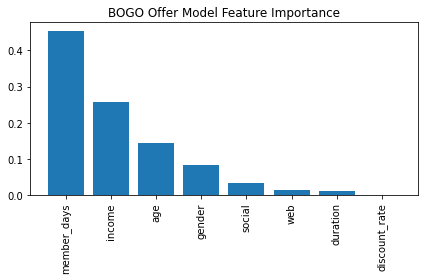

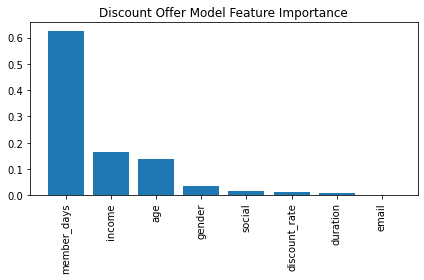

In [488]:
drop_col=['customer_id', 'offer_id', 'offer_effective']
stand_col=['discount_rate', 'duration', 'age', 'income', 'member_days']

X_train_bogo, X_test_bogo, y_train_bogo, y_test_bogo = prep_model(bogo_df,drop_col,stand_col)
X_train_disc, X_test_disc, y_train_disc, y_test_disc = prep_model(disc_df,drop_col,stand_col)


bogo_importances = bogo2.feature_importances_
disc_importances = disc2.feature_importances_

# Sort the feature importance in descending order
bogo_sorted_indices = np.argsort(bogo_importances)[::-1]
disc_sorted_indices = np.argsort(disc_importances)[::-1]

plt.title('BOGO Offer Model Feature Importance')
plt.bar(range(X_train_bogo.shape[1]), bogo_importances[bogo_sorted_indices], align='center')
plt.xticks(range(X_train_bogo.shape[1]), X_train_bogo.columns[bogo_sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

plt.title('Discount Offer Model Feature Importance')
plt.bar(range(X_train_disc.shape[1]), disc_importances[disc_sorted_indices], align='center')
plt.xticks(range(X_train_disc.shape[1]), X_train_disc.columns[disc_sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

From the feature importance results, we can  see that the most important feature for both offer types is member_days. For BOGO offer, income, age and gender are less important but still has some proportion, compared to the other features. So we can try to remove some low important features from BOGO offer model. Similiarly, for Discount offer.

In [489]:
bogo_df.columns

Index(['customer_id', 'offer_id', 'duration', 'web', 'social', 'gender', 'age',
       'income', 'member_days', 'offer_effective', 'discount_rate'],
      dtype='object')

In [490]:
# BOGO Offer Model 3
drop_col=['customer_id','offer_id','offer_effective', 'duration', 'web', 'discount_rate']
stand_col=['age', 'income', 'member_days']
X_train, X_test, y_train, y_test = prep_model(bogo_df,drop_col,stand_col)
bogo3 = RandomForestClassifier(n_estimators = 70, max_depth=10, random_state=0)
print("BOGO Offer Model 3:")
print("-----------------------------------------------------")
results = build_model(X_train, X_test, y_train, y_test, bogo3)

BOGO Offer Model 3:
-----------------------------------------------------
Model training time: 0.6068
Model prediction time: 0.1759
RandomForestClassifier trained on 13358 samples.
Training accuracy:0.7868
Test accuracy:0.7266
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1433
           1       0.76      0.76      0.76      1907

    accuracy                           0.73      3340
   macro avg       0.72      0.72      0.72      3340
weighted avg       0.73      0.73      0.73      3340



In [491]:
# Discount Offer Model 3
drop_col=['customer_id','offer_id','offer_effective', 'duration', 'email', 'discount_rate', 'social']
stand_col=['income', 'age', 'member_days']
X_train, X_test, y_train, y_test = prep_model(disc_df,drop_col,stand_col)
disc3 = RandomForestClassifier(n_estimators = 70, max_depth=10, random_state=0)
print("Discount Offer Model 3:")
print("-----------------------------------------------------")
results = build_model(X_train, X_test, y_train, y_test, disc3)

Discount Offer Model 3:
-----------------------------------------------------
Model training time: 0.6352
Model prediction time: 0.1243
RandomForestClassifier trained on 11272 samples.
Training accuracy:0.8369
Test accuracy:0.7601
              precision    recall  f1-score   support

           0       0.57      0.37      0.45       740
           1       0.80      0.90      0.85      2078

    accuracy                           0.76      2818
   macro avg       0.68      0.63      0.65      2818
weighted avg       0.74      0.76      0.74      2818



From the above results, we can see that dropping some low importance features improves our model a little bit but not significantly, for both offer types.

## Conclusion

### 1. Reflection

At the beginning of this project, I brought up two questions to focus on:

1. what are the main features that affect someone on responding the offers


2. build model to predict whether or not someone will respond to an offer

For question 1, based on the feature importance results for both BOGO and discount offer types, the top 3 main features are membership tenure, income, and age. The membership tenure is much more important than the other 2 features.

For question 2, I used seperate models to predict if the customer will respond to an BOGO or discount offer, in another word, if the offer is effective on the customer. I used Random Forest Classifier model for both offer types, and got accuracy score 72.66% for BOGO and 76.01% for discount. Although I was expecting to see the score over 80%, the current accuracy would be acceptable to send offers from business aspect. 

### 2. Challenge

The biggest challenge for this project is the structure of the transcript data.

In order to build the classification model and answer the two questions, I need to define if an offer is effective to an customer, using the transcript data. This is the most difficult and challenging part. Because all transaction events do not have offer id linked, so we cannot 100% sure which offer the customer applied during the transaction. So I decided to use the time sequence of the other events to identify if an offer is effective or not, because other events have the offer id linked. 

However, during the data exploration, we noticed that there is no "offer completed" event for informational offers. In that case, I cannot tell if the customer was affected by the offer or not, because we cannot link the transaction. So I decided to only focus on BOGO and discount offers for this project.

We classified two groups for effective/ineffective offer as shown below. By doing that, we were actually dropping some pairs that potentially could be calssified into these two groups.
1. offer received -> offer viewed -> offer completed (effective)
2. offer received -> offer viewed (ineffective)




Another challenge is preparing data for model implementation. To build the model, we need to encoding some categorical variables, like channels and gender. Also, that means our training data includes both scale and categorical features, so we need to treat them differently when doing the feature standardization.

### 3. Improvement

Because of the time constraint, I didn't get the model accuracy score over 80%. There are some aspects of the implementation could be improved.

1. The method to identify the offer effectiveness could be improved. Based on current information, we may consider to bring more cases into the ineffective group, like completed offer before viewing the offer or even did not view the offer. Also, we can study this case more deeply because in this case, it could indicate that this customer will purchase regardless of the offer, so in business perspective, not send an offer to them may be a better choice. Another idea is to further restrict the effective offer group by checking the time between "offer completed" and "offer viewed". For example, if a customer completed the offer after a week of viewing the offer, then this purchase may not be affected by the offer.


2. More models could be tried and compared the performance with the current one. Also more model tuning experiments could be tried. Due to the time reason, I didn't put many parameter choices when doing the GridSearch, which could probably find better parameters if I gave more inputs. Also more feature engineering steps could be helpful to check if we can get any other new features that potentially could improve the model.